In [1]:
import glob
import os
import librosa
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
# this library helps us convert string labels into easy to handle encoded labels.
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# You should change these paths according to the path of the files on your system.
PATH_TO_TRAIN_LABELS = "data/train/train.csv"
PATH_TO_TEST_LABELS = "data/test/test.csv"
PATH_TO_TRAIN_AUDIO_FILES = "data/train/wav/"
PATH_TO_TEST_AUDIO_FILES = "data/test/wav/"
PATH_TO_SUBMISSION = "submission/"
PATH_TO_PICKLE = "pickles/"
SUBMISSION_TITLE = "nn all"

In [3]:
# Helper method to extract features from the wav files
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [4]:
# Takes a csv as input which has ids, and a path to the wav files folder.
def parse_audio_files(parent_csv,path_to_wav_files, is_label_available = True):
    data = pd.read_csv(parent_csv)
    features, labels = np.empty((0,193)), np.empty(0)
    for index, row in tqdm(data.iterrows()):
        try:
            fn = path_to_wav_files + str(row.ID) + ".wav"
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            if is_label_available == True:
                labels = np.append(labels, row.Class)
        except Exception as ex:
            print(ex)
            continue
    return np.array(features), np.array(labels)

In [5]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [6]:
train_features, train_labels_strings = parse_audio_files(PATH_TO_TRAIN_LABELS,PATH_TO_TRAIN_AUDIO_FILES)

101it [01:12,  1.39it/s]C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
930it [08:32,  1.81it/s]C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\librosa\util\utils.py:1467: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0) or np.any(X_ref < 0):
C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\librosa\util\utils.py:1480: RuntimeWarning: invalid value encountered in less
  bad_idx = (Z < np.finfo(dtype).tiny)


Audio buffer is not finite everywhere


5435it [47:50,  1.89it/s]


In [7]:
test_features, _ = parse_audio_files(PATH_TO_TEST_LABELS,PATH_TO_TEST_AUDIO_FILES,False)

268it [02:28,  1.81it/s]C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\librosa\core\pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
3297it [29:13,  1.88it/s]


In [8]:
train_labels_strings[0:3]

array(['siren', 'street_music', 'drilling'], dtype='<U32')

In [9]:
lb = LabelEncoder()
train_labels = to_categorical(lb.fit_transform(train_labels_strings))
_check = lb.fit_transform(train_labels_strings)
_check

array([8, 9, 4, ..., 5, 5, 0], dtype=int64)

In [10]:
train_labels[0:3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [11]:
# Check if the inverse is working
_check = lb.inverse_transform(_check)
_check

C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['siren', 'street_music', 'drilling', ..., 'engine_idling',
       'engine_idling', 'air_conditioner'], dtype='<U32')

In [12]:
train_x = train_features
train_y = train_labels
test_x = test_features

--------------------------------------------------------------------------------------------------------------------------

#### Training Neural Network with TensorFlow

In [13]:
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [14]:
training_epochs = 50
n_dim = train_features.shape[1]
n_classes = train_labels.shape[1]
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [15]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [16]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

In [17]:
cost_history = np.empty(shape=[1],dtype=float)
y_pred = None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(y_,feed_dict={X: test_x})

C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


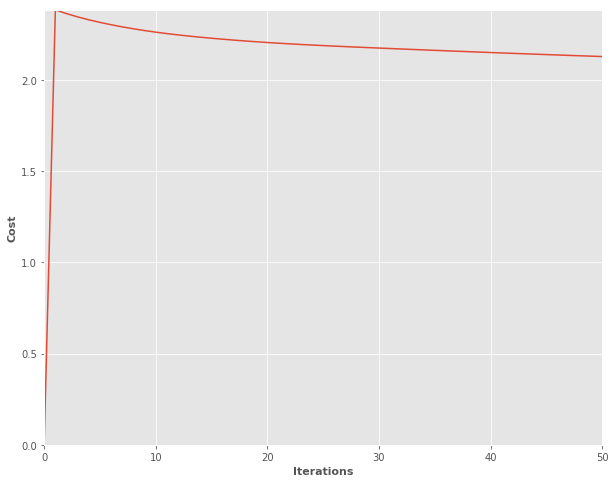

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

----------------------------------

Actualy testing on the test set

In [19]:
y_pred_one_hot = y_pred.argmax(axis=1)
y_pred_one_hot

array([7, 3, 4, ..., 7, 3, 8], dtype=int64)

In [20]:
test_labels_strings = lb.inverse_transform(y_pred_one_hot)
test_labels_strings

C:\Users\shrung\AppData\Local\Continuum\miniconda3\envs\deeplearning\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['jackhammer', 'dog_bark', 'drilling', ..., 'jackhammer',
       'dog_bark', 'siren'], dtype='<U32')

In [21]:
test = pd.read_csv(PATH_TO_TEST_LABELS)
test['Class'] = test_labels_strings

In [22]:
test.to_csv(PATH_TO_SUBMISSION + SUBMISSION_TITLE + ".csv",index=None)

In [23]:
from common import save_as_pickle

In [24]:
save_as_pickle(data=train_features, pickle_file="pickles/nn all train features.pickle")

In [25]:
save_as_pickle(data=train_labels, pickle_file="pickles/nn all train labels.pickle")

In [26]:
save_as_pickle(data=test_features, pickle_file="pickles/nn all test features.pickle")